# Test GB algorithm

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

import tsvar
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

---

## Generate toy example dataset


### V1. Small 2-dimensional toy setting

### V2. Larger setting

In [5]:
from experiments_utils import generate_parameters

dim = 10
max_jumps=10e3 * dim

param_dict = generate_parameters(dim=dim, base_range=[0.05, 0.05], adj_range=[0.1, 0.2], seed=11)

mu = torch.tensor(param_dict['baseline'])
beta = torch.tensor(param_dict['beta'])
alpha = torch.tensor(param_dict['adjacency'])

print('Baseline:')
print(mu.numpy().round(2))
print('Alpha:')
print(alpha.numpy().round(2))
print('Beta:')
print(beta.numpy().round(2))

Baseline:
[ 0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05  0.05]
Alpha:
[[ 0.11  0.12  0.00  0.12  0.18  0.19  0.00  0.11  0.00  0.00]
 [ 0.00  0.12  0.12  0.00  0.00  0.12  0.00  0.17  0.15  0.11]
 [ 0.14  0.00  0.14  0.00  0.13  0.00  0.19  0.00  0.00  0.14]
 [ 0.19  0.13  0.00  0.00  0.14  0.00  0.00  0.00  0.00  0.13]
 [ 0.14  0.13  0.00  0.00  0.10  0.17  0.15  0.00  0.00  0.13]
 [ 0.00  0.12  0.13  0.00  0.00  0.11  0.13  0.00  0.00  0.11]
 [ 0.00  0.00  0.15  0.00  0.13  0.19  0.00  0.00  0.00  0.17]
 [ 0.00  0.18  0.13  0.12  0.11  0.00  0.00  0.19  0.00  0.11]
 [ 0.00  0.00  0.11  0.00  0.10  0.16  0.00  0.00  0.00  0.00]
 [ 0.00  0.11  0.11  0.17  0.18  0.15  0.14  0.00  0.11  0.00]]
Beta:
[[ 0.73  0.11  0.89  0.86  0.17  0.63  0.02  0.12  0.32  0.16]
 [ 0.76  0.82  0.34  0.32  0.11  0.08  0.71  0.60  0.06  0.48]
 [ 0.40  0.85  0.72  0.60  0.55  0.95  0.99  0.34  0.24  0.80]
 [ 0.06  0.36  0.07  0.32  0.07  0.29  0.79  0.91  0.79  0.56]
 [ 0.62  0.36  0.17  0.44  0.73 

### Simulate a realization

In [6]:
coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.MultivariateWoldSimulatorOther(
    mu_a=mu, alpha_ba=alpha, beta_ba=beta)
events = wold_sim.simulate(max_jumps=max_jumps, seed=1234)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
end_time = max(map(max, events))
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))
print("    - Events:")
for i, events_i in enumerate(events):
    print(f"      - dim {i:>2d} ({len(events_i):>5d} events):", events_i.numpy())

  - Simulate lots of data...
    - Simulated 100,000 events with end time: 43380.59375
    - Events:
      - dim  0 ( 8324 events): [     1.39      2.98     11.44 ...  43357.89  43370.88  43372.73]
      - dim  1 (12055 events): [     2.04      2.10      3.43 ...  43375.81  43377.50  43378.11]
      - dim  2 (11529 events): [     1.70      5.15      5.16 ...  43366.12  43369.10  43374.16]
      - dim  3 ( 6273 events): [     3.67      5.88     13.23 ...  43364.19  43374.50  43379.12]
      - dim  4 (13492 events): [     0.61      2.10      3.19 ...  43362.09  43374.03  43380.59]
      - dim  5 (15108 events): [     1.16      1.81      4.38 ...  43366.21  43368.67  43377.57]
      - dim  6 ( 9612 events): [     3.90      9.25     13.03 ...  43357.92  43363.57  43368.16]
      - dim  7 ( 6859 events): [     1.71      7.51      8.54 ...  43360.66  43369.35  43375.08]
      - dim  8 ( 5466 events): [     5.74      7.33     10.76 ...  43349.46  43350.56  43359.27]
      - dim  9 (11282 even

---

In [13]:
from gb import GrangerBusca

def run_gb(num_iter):
    # Define model
    granger_model = GrangerBusca(
        alpha_prior=1.0/len(events), 
        num_iter=num_iter, 
        metropolis=True, 
        beta_strategy='busca',
    ) #recommended parameters
    granger_model.fit(events)

    adj_hat = granger_model.Alpha_.toarray()
    adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
    return adj_hat

In [14]:
num_iter_range = np.logspace(np.log10(300), np.log10(30000), 10).astype(int)
num_runs = 10

res = list()

for i, num_iter in enumerate(num_iter_range):
    for j in range(num_runs):
        print(f"{i*num_runs + j + 1}/{num_runs * len(num_iter_range)} - {num_iter}")
        adj_hat = run_gb(num_iter)
        res.append({
            'num_iter': num_iter,
            'j': j,
            'adj_hat': adj_hat,
        })

1/100 - 300
2/100 - 300
3/100 - 300
4/100 - 300
5/100 - 300
6/100 - 300
7/100 - 300
8/100 - 300
9/100 - 300
10/100 - 300
11/100 - 500
12/100 - 500
13/100 - 500
14/100 - 500
15/100 - 500
16/100 - 500
17/100 - 500
18/100 - 500
19/100 - 500
20/100 - 500
21/100 - 834
22/100 - 834
23/100 - 834
24/100 - 834
25/100 - 834
26/100 - 834
27/100 - 834
28/100 - 834
29/100 - 834
30/100 - 834
31/100 - 1392
32/100 - 1392
33/100 - 1392
34/100 - 1392
35/100 - 1392
36/100 - 1392
37/100 - 1392
38/100 - 1392
39/100 - 1392
40/100 - 1392
41/100 - 2322
42/100 - 2322
43/100 - 2322
44/100 - 2322
45/100 - 2322
46/100 - 2322
47/100 - 2322
48/100 - 2322
49/100 - 2322
50/100 - 2322
51/100 - 3874
52/100 - 3874
53/100 - 3874
54/100 - 3874
55/100 - 3874
56/100 - 3874
57/100 - 3874
58/100 - 3874
59/100 - 3874
60/100 - 3874
61/100 - 6463
62/100 - 6463
63/100 - 6463
64/100 - 6463
65/100 - 6463
66/100 - 6463
67/100 - 6463
68/100 - 6463
69/100 - 6463
70/100 - 6463
71/100 - 10781
72/100 - 10781
73/100 - 10781
74/100 - 10781

In [54]:
import pickle
with open('test-GB-convergence.pickle', 'wb') as f:
    pickle.dump(res, f)

In [17]:
df = pd.DataFrame(res)
df

,num_iter,j,adj_hat
0,300,0,"[[0.3164745258460394, 0.10803272592041652, 0.0..."
1,300,1,"[[0.270219903093552, 0.09690644800596347, 0.00..."
2,300,2,"[[0.2274241302738712, 0.17468541820873426, 0.0..."
3,300,3,"[[0.2678670874327084, 0.1266010766660479, 0.0,..."
4,300,4,"[[0.2834105653382762, 0.038368860055607044, 0...."
...,...,...,...
95,30000,5,"[[0.2394083272461651, 0.0, 0.00876552227903579..."
96,30000,6,"[[0.27322206095791, 0.14150943396226415, 0.008..."
97,30000,7,"[[0.30652702449971947, 0.18552459322984852, 0...."
98,30000,8,"[[0.260114539072603, 0.004803251431738408, 0.0..."


In [19]:
from sklearn.metrics import jaccard_score

In [52]:
vals = {}

for num_iter in num_iter_range:
    vals[num_iter] = list()
    for i in df[df.num_iter == num_iter].index:
        for j in df[df.num_iter == num_iter].index:
            if i == j:
                continue
            arr1 = np.array(df.loc[i]['adj_hat']).flatten() > 0.05
            arr2 = np.array(df.loc[j]['adj_hat']).flatten() > 0.05
            vals[num_iter].append(np.sum(arr1 ^ arr2) / len(arr1))

Text(0.5, 1.0, 'Analysis of variability of estimated \nadjacency matrix by GB')

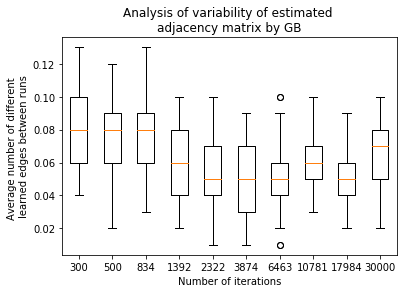

In [53]:
plt.boxplot(vals.values(), labels=vals.keys());
plt.xlabel('Number of iterations')
plt.ylabel('Average number of different \nlearned edges between runs')
plt.title('Analysis of variability of estimated \nadjacency matrix by GB')